In [101]:
import pandas as pd ## datayi oku
import re ## texti temizle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer ## tfidf/count hesaplamalari yap (kelime/phrase icin)
import numpy as np ## matrixlerde toplama keyf
from sklearn.cluster import KMeans ## gruplamak istersek
import spacy ## process et (tokenize, pos tag, lemmatize etc)
from nltk import RegexpParser ## kurallara gore phrase extract et
import operator
from collections import Counter
import nltk
from textblob import TextBlob
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, multilabel_confusion_matrix, f1_score
import shap
import matplotlib.pyplot as plt

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
df = pd.read_csv('bestbuy/final_results.csv')
#rating_df_1 = df[df['rating'] == 1].reset_index(drop=True).iloc[:1000]
#rating_df_2 = df[df['rating'] == 2].reset_index(drop=True).iloc[:1000]
#rating_df_3 = df[df['rating'] == 3].reset_index(drop=True).iloc[:1000]
#rating_df_4 = df[df['rating'] == 4].reset_index(drop=True).iloc[:1000]
#rating_df_5 = df[df['rating'] == 5].reset_index(drop=True).iloc[:1000]
#df = pd.concat([rating_df_1,rating_df_2,rating_df_3,rating_df_4,rating_df_5],axis = 0).reset_index(drop=True)
df.head()

# Dataframe Cleaning

In [ ]:
df['helpful_clean'] = df['helpful'].apply(lambda x: x.split('. ')[1])
df['unhelpful_clean'] = df['unhelpful'].apply(lambda x: x.split('. ')[1])
df.drop(columns = ['helpful', 'unhelpful'],inplace = True)
df.head()

In [ ]:
df['helpful'] = df.helpful_clean.apply(lambda x: x.split()[0])
df['unhelpful'] = df.unhelpful_clean.apply(lambda x: x.split()[0])

In [ ]:
df.drop(columns = ['helpful_clean', 'unhelpful_clean'],inplace = True)
df.head()

In [ ]:
punc_pattern = r"(\.|\,|\:|\;|\'|\"\-|\=|\\|\<|\>|\?|\)|\(|\*|\&|\^|\%|\$|\#|\@|\!|\~|\`)"
df['cleaned_body'] = df['body'].apply(lambda x: re.sub('\n',' ', re.sub('\r',' ', re.sub(r'\=',' ',x))))
df['dalyarrak deniz'] = df['cleaned_body'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(str(''.join(i for i in x if ord(i)<128))) if len(token.tag_) > 0 and token.tag_[0] in ['N','J']]))
df['processed_body'] = df['dalyarrak deniz'].apply(lambda x: re.sub(r'\s{2,}', ' ', re.sub(punc_pattern, ' ', x)).strip())
df.head()

In [ ]:
df['clean_title'] = df['title'].fillna('').apply(lambda x: re.sub('\n',' ', re.sub('\r',' ', re.sub(r'\=',' ',x))))
df['processed_title'] = df['clean_title'].apply(lambda x: re.sub(r'\s{2,}', ' ', re.sub(punc_pattern, ' ', x)).strip().lower())
df.drop(columns=['cleaned_body','dalyarrak deniz','clean_title'],inplace = True)
df.head()

In [ ]:
df['recommend_flag'] = df['recommend a friend'].apply(lambda x: 1 if x == 'Yes' else 0)
df.drop(columns=['recommend a friend'],inplace = True)
df.head()

# Helpful/Unhelpful distribution with respect to Rating

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C7CC323550>,
      dtype=object)

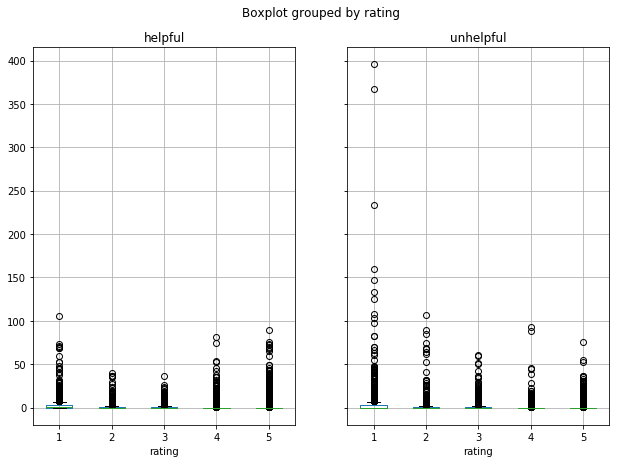

In [123]:
df.boxplot(column=['helpful','unhelpful'], by='rating', figsize=(10,7))

# Recommend a flag counts with respect to Rating

rating
1       43
2       60
3     1077
4    13594
5    52915
Name: recommend_flag, dtype: int64


Text(0,0.5,'Count of Reviews')

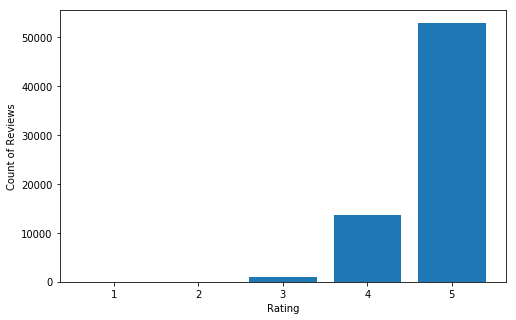

In [118]:
rec_counts = df.groupby('rating').agg('recommend_flag').sum()
print(rec_counts)
fig, ax = plt.subplots(figsize=(8,5))
ax.bar([i for i in range(1,6)], [rec_counts[i] for i in range(1,6)])
ax.set_xlabel('Rating')
ax.set_ylabel('Count of Reviews')

# Checking processed review length to remove noise from training set

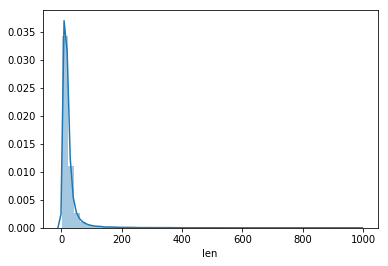

In [3]:
df['all_text'] = df['processed_title'] + ' ' + df['processed_body']
df['len'] = df['all_text'].apply(lambda x: len(x.split()))
df['len'].value_counts

sns.distplot(df['len'])

In [4]:
df = df[(df['len'] >= 8) & (df['len'] <= 100)]

In [5]:
#df['product title new'] = df['product title'].apply(lambda x: re.sub(r'\s{2,}',' ', ' '.join(''.join(i for i in x if ord(i)<128).split('-')[:2])).strip())
#j = df['product title new'].value_counts()
#[a for a in df['product title new'].unique() if j[a] >= 500]
#df.head()

# TF-IDF Vectorizing

In [6]:
tfidf_body = TfidfVectorizer(min_df=10, max_df=0.4, stop_words='english', ngram_range=(1,2))
tfidf_body.fit(df['processed_body'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [7]:
tfidf_title = TfidfVectorizer(min_df=10, max_df=0.4, stop_words='english', ngram_range=(1,2))
tfidf_title.fit(df['processed_title'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [8]:
vocab = list(set([k for k in list(tfidf_body.vocabulary_.keys()) + list(tfidf_title.vocabulary_.keys())]))
vocab = {k:i for i,k in enumerate(vocab)}

In [9]:
rating_texts = []
df['all_text'] = df['processed_title'] + ' ' + df['processed_body']
a = df.groupby('rating')
vocabs = []
for group in a.groups:
    print(group)
    current_group = a.get_group(group)
    curr_vect = TfidfVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2))
    curr_vect.fit(current_group['all_text'])
    vocabs.extend(list(curr_vect.vocabulary_.keys()))
    rating_texts.append(' '.join(current_group['all_text'].tolist()))
vocabs = list(set(vocabs))
print(len(vocabs))
print(vocabs)

1
2
3
4
5
8231


['make easy', 'hdmi usb', 'labtop', 'know need', 'fast speed', 'experience good', '730', 'with it', 'replace be', 'buy second', 'work screen', 'watch netflix', 'inch be', 'keep laptop', 'pro like', 'use be', 'board', 'be less', 'great portability', 'willing', 'i5 gb', 'have speed', 'cheap laptop', 'attend', 'be pack', 'nice sleek', 'use start', 'reliable great', 'complaint love', 'laptop handle', 'well have', 'gold', 'ok be', 'act', 'great condition', 'osx', 'handle everything', 'seems', 'and great', 'great power', 'day use', 'outstanding be', 'fast perfect', 'rtx', 'bother', 'meet requirement', 'everyone love', 'charging', 'loading', 'set love', 'use device', 'coding', 'video', 'use powerful', 'purchase granddaughter', 'feature love', 'previous computer', 'book buy', 'small thin', 'thing need', 'difference be', 'purchase daughter', 'outdate', 'drive do', 'buy usb', 'work day', 'smooth', 'online college', 'you get', 'tablet great', 'practice', 'box item', 'weight work', 'purchase need'

In [10]:
rating_tfidf = TfidfVectorizer(min_df = 1, max_df = 3, ngram_range=(1,2))
rating_tfidf.fit(rating_texts)
len(rating_tfidf.vocabulary_)

335331

In [11]:
filtered_vocab = [word for word in rating_tfidf.vocabulary_.keys() if word in vocabs]
filtered_vocab = {word:i for i,word in enumerate(filtered_vocab)}

In [12]:
len(filtered_vocab)

2890

In [13]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df['all_text'] = shuffled_df['processed_title'] + ' ' + shuffled_df['processed_body']
shuffled_df = shuffled_df[(shuffled_df['rating'] == 1) | (shuffled_df['rating'] == 5)].reset_index(drop = True)
shuffled_df['adj_rating'] = shuffled_df['rating'].apply(lambda x: 1 if x == 5 else 0)
labels = pd.get_dummies(shuffled_df['adj_rating']).reset_index(drop=True)

# Grid Search

In [ ]:
grid_vect = CountVectorizer(ngram_range = (1,2),binary = True, vocabulary = vocab)
x = grid_vect.fit_transform(shuffled_df['all_text']).toarray()
x = np.append(x,shuffled_df[['recommend_flag','helpful','unhelpful']].values, axis=1)
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), 
                          param_grid = {'max_depth':[4,6,8,10,12],
                                       'max_leaf_nodes':[25,50,100,None],
                                       'max_features':[100,200,500,None],
                                       'min_samples_leaf':[1,5,10,20,30]},
                          cv = 5,
                          n_jobs = -1,
                          verbose = True,
                          scoring = 'roc_auc')

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

# Decision Tree

In [38]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3)
for train_idx, test_idx in sss.split(shuffled_df['all_text'], shuffled_df['adj_rating']):
    count_all_text = CountVectorizer(ngram_range = (1,2),binary = True, vocabulary = filtered_vocab)
    train_y = shuffled_df['adj_rating'].iloc[train_idx]#labels[[1,2,3,4,5]].iloc[train_idx]
    test_y = shuffled_df['adj_rating'].iloc[test_idx]#labels[[1,2,3,4,5]].iloc[test_idx]
    train_x = count_all_text.fit_transform(shuffled_df['all_text'].iloc[train_idx]).toarray()
    test_x = count_all_text.transform(shuffled_df['all_text'].iloc[test_idx]).toarray()
    train_x = np.append(train_x, shuffled_df[['recommend_flag','helpful','unhelpful']].iloc[train_idx].values, axis=1)
    test_x = np.append(test_x, shuffled_df[['recommend_flag','helpful','unhelpful']].iloc[test_idx].values, axis=1)
    model = DecisionTreeClassifier(max_features=None, max_leaf_nodes=25, min_samples_leaf=10)
    model.fit(train_x,train_y)
    test_preds = model.predict(test_x)
    test_probs = [e[1] for e in model.predict_proba(test_x)]
    #print(confusion_matrix(test_y, test_preds))
    print('\n\n')
    print('Confusion Matrix: ')
    print(confusion_matrix(test_y, test_preds))
    print('ROC AUC Score :', roc_auc_score(test_y, test_probs))
    print('Precision Score: ', precision_score(test_y, test_preds))
    print('Recall Score: ', recall_score(test_y, test_preds))
    print('F1 Score: ', f1_score(test_y, test_preds))




Confusion Matrix: 
[[  565    12]
 [   61 15878]]
ROC AUC Score : 0.9922384985304132
Precision Score:  0.9992448080553807
Recall Score:  0.9961729092163875
F1 Score:  0.9977064940777279


In [20]:
cols = list(count_all_text.vocabulary_.keys()) + ['recommend_flag','helpful','unhelpful']

In [39]:
imps = model.feature_importances_
for k,v in sorted([(cols[i],imps[i]) for i in range(len(cols))], key=operator.itemgetter(1), reverse=True):
    if v > 0:
        print(k,v)

recommend_flag 0.9818341968868654
helpful 0.013342979890543517
unhelpful 0.003921390178005681
not buy 0.0006138787895922108
be show 6.608975509711753e-05
great day 6.60429913575166e-05
com 4.506577054281017e-05
request 3.888706344425511e-05
everything more 3.7219502857158485e-05
school graduation 3.424917169450947e-05


# Logistic Regression

In [47]:
log_model = LogisticRegression(penalty='l1', tol=0.0001, C=1.0, 
                               class_weight='balanced', solver='liblinear', max_iter=100, 
                               verbose=1, n_jobs=-1)
log_model.fit(train_x, train_y)
test_preds_log = log_model.predict(test_x)
test_probs = [e[1] for e in log_model.predict_proba(test_x)]
test_probs_full = log_model.predict_proba(test_x)
print('\n\n')
print('Confusion Matrix: ')
print(confusion_matrix(test_y, test_preds_log))
print('ROC AUC Score :', roc_auc_score(test_y, test_probs))
print('Precision Score: ', precision_score(test_y, test_preds_log))
print('Recall Score: ', recall_score(test_y, test_preds_log))
print('F1 Score: ', f1_score(test_y, test_preds_log))

c:\users\dkaraca\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]


Confusion Matrix: 
[[  567    10]
 [  119 15820]]
ROC AUC Score : 0.996079996494434
Precision Score:  0.9993682880606444
Recall Score:  0.9925340360122968
F1 Score:  0.9959394378167395


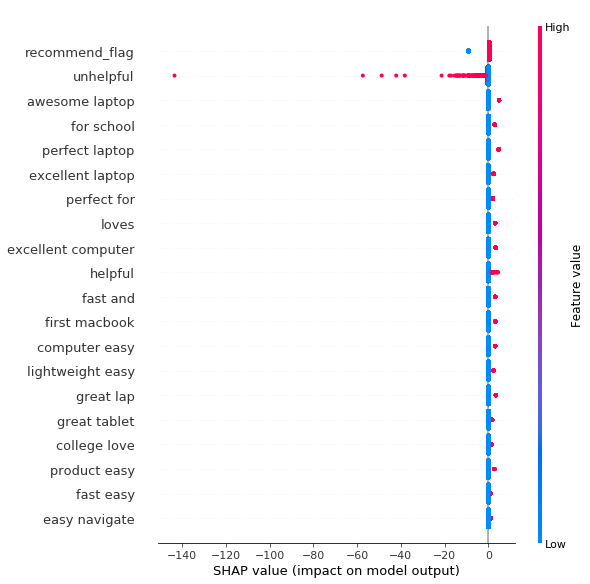

In [43]:
explainer = shap.LinearExplainer(log_model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(test_x)
X_test_array = test_x
shap.summary_plot(shap_values, X_test_array, feature_names=cols)

In [40]:
for i,val in sorted([(cols[i], log_model.coef_[0][i]) for i in range(len(cols)) if log_model.coef_[0][i]>0], key=operator.itemgetter(1), reverse=True):
    print(i,val)

recommend_flag 9.405385461380108
awesome laptop 4.871773030032522
perfect laptop 4.6815273876450245
great lap 3.3824340724515096
excellent computer 3.315830790419368
fast and 3.1355632534981996
loves 3.0723290196499002
first macbook 3.0668820605437306
computer easy 3.063688702145961
for school 2.936633403027486
product easy 2.7129586063269264
good memory 2.691067993750949
good good 2.5783039836525887
great small 2.5714754569999076
absolutely 2.568379259988917
excellent laptop 2.3735539526695546
laptop excellent 2.3496730257732783
lightweight easy 2.313400747013517
perfect for 2.041439465764904
amazing light 1.8577999172657265
great tablet 1.6518762931211317
awesome be 1.6354814348580364
college love 1.3774937731866361
easy navigate 1.1405807423423808
great macbook 1.0719811422694383
all around 1.0356937862858395
serve need 0.9443795439397693
macbook last 0.9206206354547106
fast easy 0.873870752055112
son love 0.8253738957315708
new feature 0.819056019863247
excellent product 0.81284453

In [54]:
test_df = shuffled_df.iloc[test_idx].reset_index(drop=True)
test_df['PRED'] = test_preds_log
false_pos = test_df[(test_df['adj_rating'] == 0) & (test_df['PRED'] == 1)]
false_pos_x = count_all_text.transform(false_pos['all_text']).toarray()
false_pos_x = np.append(false_pos_x, false_pos[['recommend_flag','helpful','unhelpful']].values, axis=1)
false_pos_x = pd.DataFrame(false_pos_x, columns=cols)

In [62]:
explainer = shap.LinearExplainer(log_model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(false_pos_x)
shap.force_plot(explainer.expected_value, shap_values[0], false_pos_x.iloc[0])

In [63]:
shap.force_plot(explainer.expected_value, shap_values[1], false_pos_x.iloc[1])

In [64]:
shap.force_plot(explainer.expected_value, shap_values[2], false_pos_x.iloc[2])

In [65]:
shap.force_plot(explainer.expected_value, shap_values[3], false_pos_x.iloc[3])

In [66]:
shap.force_plot(explainer.expected_value, shap_values[4], false_pos_x.iloc[4])

In [67]:
shap.force_plot(explainer.expected_value, shap_values[5], false_pos_x.iloc[5])

In [68]:
shap.force_plot(explainer.expected_value, shap_values[6], false_pos_x.iloc[6])

In [69]:
shap.force_plot(explainer.expected_value, shap_values[7], false_pos_x.iloc[7])

In [70]:
shap.force_plot(explainer.expected_value, shap_values[8], false_pos_x.iloc[8])

In [71]:
shap.force_plot(explainer.expected_value, shap_values[9], false_pos_x.iloc[9])

In [85]:
false_neg = test_df[(test_df['adj_rating'] == 1) & (test_df['PRED'] == 0)]
false_neg_x = count_all_text.transform(false_neg['all_text']).toarray()
false_neg_x = np.append(false_neg_x, false_neg[['recommend_flag','helpful','unhelpful']].values, axis=1)
false_neg_x = pd.DataFrame(false_neg_x, columns=cols)
shap_values = explainer.shap_values(false_neg_x)
false_neg_x.shape

(119, 2893)

In [86]:
shap.force_plot(explainer.expected_value, shap_values[0], false_neg_x.iloc[0])

In [87]:
shap.force_plot(explainer.expected_value, shap_values[1], false_neg_x.iloc[1])

In [88]:
shap.force_plot(explainer.expected_value, shap_values[2], false_neg_x.iloc[2])

In [89]:
shap.force_plot(explainer.expected_value, shap_values[3], false_neg_x.iloc[3])

In [90]:
shap.force_plot(explainer.expected_value, shap_values[4], false_neg_x.iloc[4])

In [91]:
shap.force_plot(explainer.expected_value, shap_values[5], false_neg_x.iloc[5])

In [92]:
shap.force_plot(explainer.expected_value, shap_values[6], false_neg_x.iloc[6])

In [93]:
shap.force_plot(explainer.expected_value, shap_values[7], false_neg_x.iloc[7])

In [94]:
shap.force_plot(explainer.expected_value, shap_values[8], false_neg_x.iloc[8])

In [95]:
shap.force_plot(explainer.expected_value, shap_values[9], false_neg_x.iloc[9])

In [96]:
shap.force_plot(explainer.expected_value, shap_values[10], false_neg_x.iloc[10])

In [46]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

#shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_1.iloc[0])


In [38]:
shap_values = explainer.shap_values()

shap.force_plot(explainer.expected_value[0], shap_values[0][102,:], x_1.iloc[102])

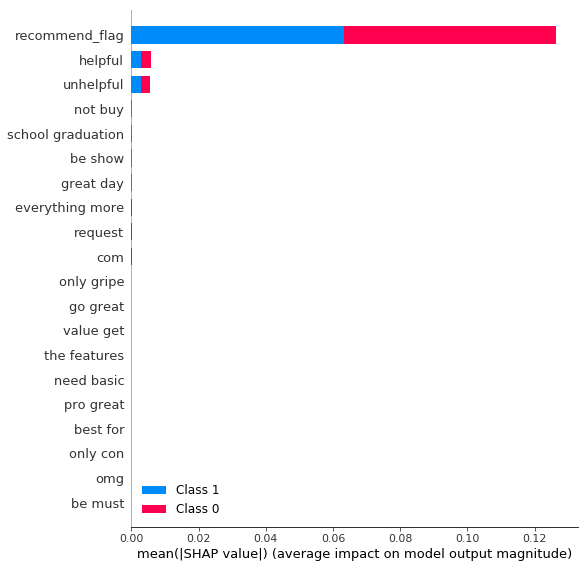

In [45]:
shap.summary_plot(shap_values=shap_values, features=test_x, feature_names=cols)